### Evaluation of downsacled CORDEX data

In [1]:
import os
import torch
import xclim
import cddlt
import random
import pyproj
import cartopy
import argparse
import torchmetrics

import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize

from cddlt.models.bicubic import Bicubic
from cddlt.models.swinir import SwinIR
from cddlt.models.edsr import EDSR
from cddlt.models.fno import FNO

from cddlt.dataloaders.downscaling_transform import DownscalingTransform
from cddlt.datasets.rekis_dataset import ReKIS
from cddlt.datasets.cordex_dataset import CORDEX

/home/kostape4/downscale/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kostape4/downscale/venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", default=32, type=int)
parser.add_argument("--epochs", default=40, type=int)
parser.add_argument("--seed", default=42, type=int)
parser.add_argument("--threads", default=4, type=int)
parser.add_argument("--upscale_factor", default=10, type=int)
parser.add_argument("--lr", default=1e-4, type=float)
parser.add_argument("--logdir", default="logs", type=str)
parser.add_argument("--variables", default=["TM"], type=list)

_StoreAction(option_strings=['--variables'], dest='variables', nargs=None, const=None, default=['TM'], type=<class 'list'>, choices=None, required=False, help=None, metavar=None)

In [3]:
args = parser.parse_args([])
cddlt.startup(args)

In [4]:
REKIS_DATA_PATH = "/mnt/personal/kostape4/data/climate/rekis/"
CORDEX_DATA_PATH = "/mnt/personal/kostape4/data/climate/cordex/"
STATIONS_DATA_PATH = "/mnt/personal/kostape4/data/climate/rekis_stations"
LOGS_PATH = "/home/kostape4/downscale/scripts/long_logs/"

In [5]:
TIME_SLICE = slice("2003", "2012")

### Data prep

In [6]:
rekis = ReKIS(
    data_path=REKIS_DATA_PATH,
    variables=args.variables,
    train_len=("1961-01-01", "1993-01-01"),
    dev_len=("1993-01-01", "2003-01-01"),
    test_len=("2003-01-01", "2013-01-01"),
    resampling="cubic_spline",
    standardize=True
)

Loading 63 NetCDF file(s)...
Loaded data shape: {'time': 11688, 'northing': 400, 'easting': 400}
Time range: 1961-01-01 00:00:00 to 1992-12-31 00:00:00
Loading 63 NetCDF file(s)...
Loaded data shape: {'time': 3652, 'northing': 400, 'easting': 400}
Time range: 1993-01-01 00:00:00 to 2002-12-31 00:00:00
Loading 63 NetCDF file(s)...
Loaded data shape: {'time': 3653, 'northing': 400, 'easting': 400}
Time range: 2003-01-01 00:00:00 to 2012-12-31 00:00:00

ReKIS dataset initalized.
train size: (11688)
dev size: (3652)
test size: (3653)



In [7]:
rekis_train = DownscalingTransform(dataset=rekis.train).dataloader(args.batch_size)
rekis_dev = DownscalingTransform(dataset=rekis.dev).dataloader(args.batch_size, shuffle=False)
rekis_test = DownscalingTransform(dataset=rekis.test).dataloader(args.batch_size, shuffle=False)

In [8]:
cordex = CORDEX(
    data_path=CORDEX_DATA_PATH,
    variables=args.variables,
    dev_len=("2003-01-01", "2013-01-01"),
    test_len=("2012-01-01", "2013-01-01"),
    standardize=True,
    standard_params=rekis.standard_params
)

Loading 34 NetCDF file(s)...
Loaded data shape: {'time': 3653, 'y': 40, 'x': 40}
Time range: 2003-01-01 12:00:00 to 2012-12-31 12:00:00
Loading 34 NetCDF file(s)...
Loaded data shape: {'time': 366, 'y': 40, 'x': 40}
Time range: 2012-01-01 12:00:00 to 2012-12-31 12:00:00

CORDEX dataset initalized.
dev size: (3653)
test size: (366)



In [9]:
cordex_dev_loader = DownscalingTransform(dataset=cordex.dev).dataloader(args.batch_size, shuffle=False)

In [10]:
def plot_lr_sr(cordex: cddlt.datasets.cordex_dataset.CORDEX, pred: torch.Tensor) -> None:
    destd_cordex_dev = rekis.destandardize([cordex.dev.inputs.cpu()])[0].squeeze()
    comb = torch.cat(
        [destd_cordex_dev[i].flatten(), pred[i].flatten()],
    )
    
    vmin, vmax = torch.min(comb), torch.max(comb)
    norm = Normalize(vmin=vmin, vmax=vmax)

    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    axes[0].set_title("LR")
    im1 = axes[0].imshow(destd_cordex_dev[i, ...], norm=norm)
    
    axes[1].set_title("SR")
    im2 = axes[1].imshow(pred.squeeze()[i, ...], norm=norm)
    
    cbar = fig.colorbar(im2, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label("°C")
    plt.show()

#### Stations

In [14]:
stations = (
    pd.read_csv(f"{STATIONS_DATA_PATH}/Stationsliste.txt", index_col="Stat_ID")
)
stations = stations[~stations.index.duplicated(keep='first')]

In [15]:
geometry = gpd.points_from_xy(stations["Laenge"], stations["Breite"], crs="EPSG:4326")
stations = gpd.GeoDataFrame(stations, geometry=geometry)
stations = stations.to_crs(31468)
stations["easting"] = stations.geometry.x
stations["northing"] = stations.geometry.y

In [16]:
geometry = gpd.points_from_xy(stations["Laenge"], stations["Breite"], crs="EPSG:4326")
stations = gpd.GeoDataFrame(stations, geometry=geometry)
stations = stations.to_crs(31468)
stations["easting"] = stations.geometry.x
stations["northing"] = stations.geometry.y
stations = stations.query("4335000.0 <= easting <= 4735000.0 and 5555000.0 <= northing <= 5955000.0")
stations

,Laenge,Breite,Hoehe,Name,geometry,easting,northing
Stat_ID,,,,,,,
DWD_12,10.186000,52.381000,61.0,Abbensen,POINT (4376587.138 5806843.945),4.376587e+06,5.806844e+06
DWD_13,11.289000,51.615000,300.0,Abberode,POINT (4450857.049 5720304.152),4.450857e+06,5.720304e+06
DWD_26,10.054000,52.550000,41.0,Adelheidsdorf,POINT (4368106.418 5825880.477),4.368106e+06,5.825880e+06
DWD_31,10.433000,53.283000,25.0,Adendorf,POINT (4395591.283 5906818.623),4.395591e+06,5.906819e+06
DWD_32,9.933000,52.000000,194.0,Adenstedt,POINT (4358153.726 5764918.45),4.358154e+06,5.764918e+06
...,...,...,...,...,...,...,...
CZ_U7CEJI01,13.586900,50.687800,740.0,Èeský Jiřetín,POINT (4612246.237 5618115.479),4.612246e+06,5.618115e+06
CZ_U7HEJN01,15.182800,50.885000,397.0,Hejnice,POINT (4724058.88 5643681.138),4.724059e+06,5.643681e+06
CZ_U7KAME01,13.331023,50.513314,590.0,"VD Kamenièka, přehrada",POINT (4594513.756 5598349.969),4.594514e+06,5.598350e+06


In [17]:
stations.columns

Index(['Laenge', 'Breite', 'Hoehe', 'Name', 'geometry', 'easting', 'northing'], dtype='object')

In [18]:
measurements = (
    pd.read_csv(
        "/mnt/personal/kostape4/data/climate/rekis_stations/TM.csv",
        decimal=",",
        sep=";",
        index_col=["zeit"],
        parse_dates=True,
    )
    .loc[TIME_SLICE]
    .reset_index()
    .melt(value_name="TM", id_vars="zeit", var_name="Stat_ID")
    .sort_values(["Stat_ID", "zeit"])
    .set_index("Stat_ID")
    .join(stations, how="inner")
)
measurements

,zeit,TM,Laenge,Breite,Hoehe,Name,geometry,easting,northing
Stat_ID,,,,,,,,,
CZ_H3PODE01,2003-01-01 00:00:00+00:00,-6.8,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06
CZ_H3PODE01,2003-01-02 00:00:00+00:00,5.3,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06
CZ_H3PODE01,2003-01-03 00:00:00+00:00,6.4,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06
CZ_H3PODE01,2003-01-04 00:00:00+00:00,0.6,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06
CZ_H3PODE01,2003-01-05 00:00:00+00:00,-5.0,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06
...,...,...,...,...,...,...,...,...,...
PL_5101,2012-12-27 00:00:00+00:00,4.5,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06
PL_5101,2012-12-28 00:00:00+00:00,-0.8,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06
PL_5101,2012-12-29 00:00:00+00:00,1.6,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06


In [19]:
stations_xr = measurements.to_xarray()
stations_xr

<xarray.Dataset> Size: 118MB
Dimensions:   (Stat_ID: 1472159)
Coordinates:
  * Stat_ID   (Stat_ID) object 12MB 'CZ_H3PODE01' 'CZ_H3PODE01' ... 'PL_5101'
Data variables:
    zeit      (Stat_ID) object 12MB 2003-01-01T00:00:00+00:00 ... 2012-12-31T...
    TM        (Stat_ID) float64 12MB -6.8 5.3 6.4 0.6 -5.0 ... -0.8 1.6 1.4 3.1
    Laenge    (Stat_ID) float64 12MB 15.11 15.11 15.11 ... 15.33 15.33 15.33
    Breite    (Stat_ID) float64 12MB 50.15 50.15 50.15 50.15 ... 50.9 50.9 50.9
    Hoehe     (Stat_ID) float64 12MB 196.0 196.0 196.0 ... 754.0 754.0 754.0
    Name      (Stat_ID) object 12MB 'Podìbrady' ... 'ŚWIERADÓW-ZDRÓJ'
    geometry  (Stat_ID) geometry 12MB POINT (4722587.777732876 5561210.642312...
    easting   (Stat_ID) float64 12MB 4.723e+06 4.723e+06 ... 4.735e+06 4.735e+06
    northing  (Stat_ID) float64 12MB 5.561e+06 5.561e+06 ... 5.646e+06 5.646e+06

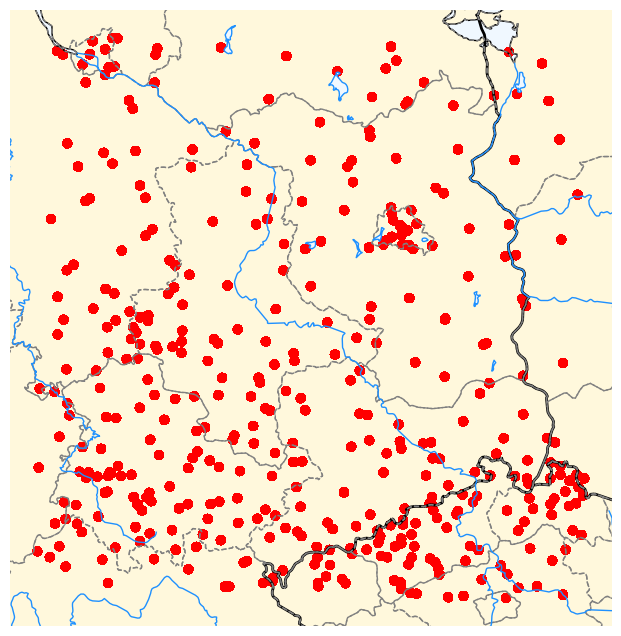

In [20]:
fig, ax = plt.subplots(subplot_kw={"projection": cartopy.crs.UTM(33)}, figsize=(8, 8))

ax.add_feature(cartopy.feature.LAND, facecolor="cornsilk") #whitesmoke
ax.add_feature(cartopy.feature.OCEAN, facecolor="aliceblue")
ax.add_feature(cartopy.feature.BORDERS, edgecolor="black", linewidth=2)
ax.add_feature(cartopy.feature.COASTLINE, edgecolor="black", linewidth=1)
ax.add_feature(cartopy.feature.STATES, edgecolor="gray", linestyle="--", linewidth=1)
ax.add_feature(cartopy.feature.RIVERS, edgecolor="dodgerblue", linewidth=1)
ax.add_feature(cartopy.feature.LAKES, edgecolor="dodgerblue", facecolor="aliceblue", linewidth=1)
ax.axis("off")

stations_xr.plot.scatter(
    x="easting",
    y="northing",
    ax=ax,
    transform=cartopy.crs.epsg(rekis.test.dataset.coords["crs"].attrs["epsg_code"]),
    color="red", 
    edgecolor="none",
    alpha=0.80,
    s=50,
    rasterized=True
)

#plt.savefig("tm_stations_map.pdf", dpi=300, bbox_inches="tight")
plt.show()

#### ReKIS

In [21]:
std_rekis_test = rekis.test.targets
rekis_test = rekis.destandardize([std_rekis_test])[0]
rekis_test.shape

torch.Size([3653, 1, 400, 400])

In [22]:
rekis_test = xr.DataArray(
    rekis_test.squeeze(),
    dims=("time", "northing", "easting"),
    coords={
        "time": rekis.test.dataset.coords["time"],
        "northing": rekis.test.dataset.coords["northing"],
        "easting": rekis.test.dataset.coords["easting"],
        "crs": rekis.test.dataset.coords["crs"],
    },
    attrs=rekis.test.dataset.attrs
)

In [23]:
measurements["rekis"] = rekis_test.sel(
    time=xr.DataArray(measurements["zeit"]),
    easting=xr.DataArray(measurements["easting"]),
    northing=xr.DataArray(measurements["northing"]),
    method="nearest",
)
measurements

,zeit,TM,Laenge,Breite,Hoehe,Name,geometry,easting,northing,rekis
Stat_ID,,,,,,,,,,
CZ_H3PODE01,2003-01-01 00:00:00+00:00,-6.8,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-7.3
CZ_H3PODE01,2003-01-02 00:00:00+00:00,5.3,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,5.4
CZ_H3PODE01,2003-01-03 00:00:00+00:00,6.4,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,6.5
CZ_H3PODE01,2003-01-04 00:00:00+00:00,0.6,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,0.4
CZ_H3PODE01,2003-01-05 00:00:00+00:00,-5.0,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-4.9
...,...,...,...,...,...,...,...,...,...,...
PL_5101,2012-12-27 00:00:00+00:00,4.5,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,2.9
PL_5101,2012-12-28 00:00:00+00:00,-0.8,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,-2.9
PL_5101,2012-12-29 00:00:00+00:00,1.6,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,1.9


#### CORDEX

In [24]:
cordex_orig = xr.open_mfdataset(
    "/mnt/data/climate/CORDEX/tas/tas_EUR-11_ECMWF-ERAINT_evaluation_r1i1p1_GERICS-REMO2015_v1_day_*.nc",
    decode_coords="all",
)
cordex_orig = cordex_orig["tas"].sel(time=TIME_SLICE)
cordex_orig["time"] = cordex_orig["time"].dt.floor(freq="D")
transformer = pyproj.Transformer.from_crs("EPSG:4326", cordex_orig.rio.crs, always_xy=True)
rlon, rlat = transformer.transform(measurements["Laenge"], measurements["Breite"])
measurements["rlon"] = rlon
measurements["rlat"] = rlat
measurements["cordex"] = cordex_orig.sel(
    time=xr.DataArray(measurements["zeit"]),
    rlon=xr.DataArray(measurements["rlon"]),
    rlat=xr.DataArray(measurements["rlat"]),
    method="nearest",
)
measurements["cordex"] -= 273.15
measurements

,zeit,TM,Laenge,Breite,Hoehe,Name,geometry,easting,northing,rekis,rlon,rlat,cordex
Stat_ID,,,,,,,,,,,,,
CZ_H3PODE01,2003-01-01 00:00:00+00:00,-6.8,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-7.3,-1.849871,-0.568605,0.523987
CZ_H3PODE01,2003-01-02 00:00:00+00:00,5.3,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,5.4,-1.849871,-0.568605,6.027771
CZ_H3PODE01,2003-01-03 00:00:00+00:00,6.4,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,6.5,-1.849871,-0.568605,4.790710
CZ_H3PODE01,2003-01-04 00:00:00+00:00,0.6,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,0.4,-1.849871,-0.568605,3.437225
CZ_H3PODE01,2003-01-05 00:00:00+00:00,-5.0,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-4.9,-1.849871,-0.568605,0.083862
...,...,...,...,...,...,...,...,...,...,...,...,...,...
PL_5101,2012-12-27 00:00:00+00:00,4.5,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,2.9,-1.681445,0.180302,-1.923218
PL_5101,2012-12-28 00:00:00+00:00,-0.8,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,-2.9,-1.681445,0.180302,-3.308990
PL_5101,2012-12-29 00:00:00+00:00,1.6,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,1.9,-1.681445,0.180302,-2.479401


In [25]:
cordex_orig = xr.open_mfdataset(
    "/mnt/data/climate/CORDEX/tas/tas_EUR-11_ECMWF-ERAINT_evaluation_r1i1p1_GERICS-REMO2015_v1_day_*.nc",
    decode_coords="all",
)

#### Destd evaluation

In [57]:
from typing import Dict

In [58]:
def evaluate_destd(
    model: cddlt.DLModule,
    dataloader: torch.utils.data.DataLoader,
    std_params: Dict[str, Dict[str, float]]
) -> None:

        model.eval()
        model._reset_loss()
        model._reset_metrics()

        mean = torch.tensor(std_params["TM"]["mean"], device=model.device)
        std = torch.tensor(std_params["TM"]["std"], device=model.device)
    
        for x, y in dataloader:
            eval_step(model, x, y, mean, std)

        dev_metrics_log = []
        for name, metric in model.metrics.items():
            dev_metrics_log.append(f"dev_{name}: {metric.compute().item():.4f}")
        if model.metrics: print(f"{', '.join(dev_metrics_log)}")

        print(f"Evaluation - dev_loss: {model.average_loss:.4f}")

def eval_step(
    model: cddlt.DLModule,
    x: torch.Tensor,
    y: torch.Tensor,
    mean: torch.Tensor,
    std: torch.Tensor
) -> None:

    with torch.no_grad():
        x, y = x.to(model.device), y.to(model.device)
        y_pred = model(x)
        y_pred = y_pred * std + mean
        y = y * std + mean
        loss = model.loss(y_pred, y)
        model._update_loss(loss)
        model._update_metrics(y_pred, y)

#### Bicubic

In [26]:
bicubic = Bicubic(
    upscale_factor=args.upscale_factor,
    mode="bicubic"
)

In [27]:
bicubic.configure(
    optimizer = None,
    scheduler = None,
    loss = torchmetrics.MeanSquaredError(squared=True),
    metrics={
        "mse": torchmetrics.MeanSquaredError(squared=True),
        "rmse": torchmetrics.MeanSquaredError(squared=False),
        "mae": torchmetrics.MeanAbsoluteError(),
        "psnr": torchmetrics.image.PeakSignalNoiseRatio(),
    },
    args = args
)

Bicubic(
  (loss): MeanSquaredError()
)

In [28]:
bicubic.evaluate(rekis_dev, print_loss=True)

dev_mse: 0.0012, dev_rmse: 0.0339, dev_mae: 0.0199, dev_psnr: 45.8139
Evaluation - dev_loss: 0.001146


In [38]:
evaluate_destd(bicubic, rekis_dev, rekis.standard_params)

dev_mse: 0.0677, dev_rmse: 0.2601, dev_mae: 0.1523, dev_psnr: 45.8139
Evaluation - dev_loss: 0.06735


In [29]:
bicubic_cordex = bicubic.predict(cordex_dev_loader)
bicubic_cordex = torch.cat(bicubic_cordex, dim=0)
bicubic_cordex = rekis.destandardize([bicubic_cordex.cpu()])[0]
bicubic_cordex.shape

torch.Size([3653, 1, 400, 400])

In [30]:
bicubic_xr = xr.DataArray(
    bicubic_cordex.squeeze(),
    dims=("time", "northing", "easting"),
    coords={
        "time": rekis.test.dataset.coords["time"],
        "northing": rekis.test.dataset.coords["northing"],
        "easting": rekis.test.dataset.coords["easting"],
        "crs": rekis.test.dataset.coords["crs"],
    },
    attrs=rekis.test.dataset.attrs
)

In [31]:
measurements["bicubic"] = bicubic_xr.sel(
    time=xr.DataArray(measurements["zeit"]),
    easting=xr.DataArray(measurements["easting"]),
    northing=xr.DataArray(measurements["northing"]),
    method="nearest",
)
measurements

,zeit,TM,Laenge,Breite,Hoehe,Name,geometry,easting,northing,rekis,rlon,rlat,cordex,bicubic
Stat_ID,,,,,,,,,,,,,,
CZ_H3PODE01,2003-01-01 00:00:00+00:00,-6.8,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-7.3,-1.849871,-0.568605,0.523987,0.348615
CZ_H3PODE01,2003-01-02 00:00:00+00:00,5.3,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,5.4,-1.849871,-0.568605,6.027771,5.403883
CZ_H3PODE01,2003-01-03 00:00:00+00:00,6.4,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,6.5,-1.849871,-0.568605,4.790710,4.422959
CZ_H3PODE01,2003-01-04 00:00:00+00:00,0.6,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,0.4,-1.849871,-0.568605,3.437225,2.906554
CZ_H3PODE01,2003-01-05 00:00:00+00:00,-5.0,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-4.9,-1.849871,-0.568605,0.083862,-0.111014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PL_5101,2012-12-27 00:00:00+00:00,4.5,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,2.9,-1.681445,0.180302,-1.923218,-1.240854
PL_5101,2012-12-28 00:00:00+00:00,-0.8,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,-2.9,-1.681445,0.180302,-3.308990,-2.615664
PL_5101,2012-12-29 00:00:00+00:00,1.6,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,1.9,-1.681445,0.180302,-2.479401,-1.986635


#### Bilinear

In [32]:
bilinear = Bicubic(
    upscale_factor=args.upscale_factor,
    mode="bilinear"
)

In [33]:
bilinear.configure(
    optimizer = None,
    scheduler = None,
    loss = torchmetrics.MeanSquaredError(squared=True),
    metrics={
        "mse": torchmetrics.MeanSquaredError(squared=True),
        "rmse": torchmetrics.MeanSquaredError(squared=False),
        "mae": torchmetrics.MeanAbsoluteError(),
        "psnr": torchmetrics.image.PeakSignalNoiseRatio(),
    },
    args = args
)

Bicubic(
  (loss): MeanSquaredError()
)

In [34]:
bilinear.evaluate(rekis_dev, print_loss=True)

dev_mse: 0.0013, dev_rmse: 0.0358, dev_mae: 0.0210, dev_psnr: 45.3460
Evaluation - dev_loss: 0.001276


In [41]:
evaluate_destd(bilinear, rekis_dev, rekis.standard_params)

dev_mse: 0.0754, dev_rmse: 0.2745, dev_mae: 0.1607, dev_psnr: 45.3460
Evaluation - dev_loss: 0.07502


In [35]:
bilinear_cordex = bilinear.predict(cordex_dev_loader)
bilinear_cordex = torch.cat(bilinear_cordex, dim=0)
bilinear_cordex = rekis.destandardize([bilinear_cordex.cpu()])[0]
bilinear_cordex.shape

torch.Size([3653, 1, 400, 400])

In [36]:
bilinear_xr = xr.DataArray(
    bilinear_cordex.squeeze(),
    dims=("time", "northing", "easting"),
    coords={
        "time": rekis.test.dataset.coords["time"],
        "northing": rekis.test.dataset.coords["northing"],
        "easting": rekis.test.dataset.coords["easting"],
        "crs": rekis.test.dataset.coords["crs"],
    },
    attrs=rekis.test.dataset.attrs
)

In [37]:
measurements["bilinear"] = bilinear_xr.sel(
    time=xr.DataArray(measurements["zeit"]),
    easting=xr.DataArray(measurements["easting"]),
    northing=xr.DataArray(measurements["northing"]),
    method="nearest",
)
measurements

,zeit,TM,Laenge,Breite,Hoehe,Name,geometry,easting,northing,rekis,rlon,rlat,cordex,bicubic,bilinear
Stat_ID,,,,,,,,,,,,,,,
CZ_H3PODE01,2003-01-01 00:00:00+00:00,-6.8,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-7.3,-1.849871,-0.568605,0.523987,0.348615,0.334984
CZ_H3PODE01,2003-01-02 00:00:00+00:00,5.3,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,5.4,-1.849871,-0.568605,6.027771,5.403883,5.356041
CZ_H3PODE01,2003-01-03 00:00:00+00:00,6.4,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,6.5,-1.849871,-0.568605,4.790710,4.422959,4.400250
CZ_H3PODE01,2003-01-04 00:00:00+00:00,0.6,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,0.4,-1.849871,-0.568605,3.437225,2.906554,2.878432
CZ_H3PODE01,2003-01-05 00:00:00+00:00,-5.0,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-4.9,-1.849871,-0.568605,0.083862,-0.111014,-0.120951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PL_5101,2012-12-27 00:00:00+00:00,4.5,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,2.9,-1.681445,0.180302,-1.923218,-1.240854,-1.139339
PL_5101,2012-12-28 00:00:00+00:00,-0.8,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,-2.9,-1.681445,0.180302,-3.308990,-2.615664,-2.528644
PL_5101,2012-12-29 00:00:00+00:00,1.6,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,1.9,-1.681445,0.180302,-2.479401,-1.986635,-1.953296


#### EDSR

In [38]:
edsr = EDSR(
    channels=1,
    scale_factor=10,
    features=128,
    residual_blocks=64
)

In [39]:
edsr.configure(
    optimizer = None,
    scheduler = None,
    loss = torch.nn.L1Loss(),
    metrics={
        "mse": torchmetrics.MeanSquaredError(squared=True),
        "rmse": torchmetrics.MeanSquaredError(squared=False),
        "mae": torchmetrics.MeanAbsoluteError(),
        "psnr": torchmetrics.image.PeakSignalNoiseRatio(),
    },
    args = args,
);

In [40]:
edsr.load_weights(os.path.join(LOGS_PATH, edsr.model_name))
edsr.evaluate(rekis_dev, print_loss=True)

dev_mse: 0.0000, dev_rmse: 0.0049, dev_mae: 0.0035, dev_psnr: 62.7045
Evaluation - dev_loss: 0.003546


In [46]:
evaluate_destd(edsr, rekis_dev, rekis.standard_params)

dev_mse: 0.0014, dev_rmse: 0.0372, dev_mae: 0.0272, dev_psnr: 62.7045
Evaluation - dev_loss: 0.02718


In [41]:
edsr.eval()
y_preds = []
for x, _ in cordex_dev_loader:
    x = x.to(edsr.device)
    y_pred = edsr.predict_step(x)
    y_preds.append(y_pred)

In [42]:
std_edsr_cordex = torch.cat(y_preds, dim=0)   
edsr_cordex = rekis.destandardize([std_edsr_cordex.cpu()])[0]
edsr_cordex.shape

torch.Size([3653, 1, 400, 400])

In [43]:
edsr_cordex_xr = xr.DataArray(
    edsr_cordex.squeeze(),
    dims=("time", "northing", "easting"),
    coords={
        "time": rekis.test.dataset.coords["time"],
        "northing": rekis.test.dataset.coords["northing"],
        "easting": rekis.test.dataset.coords["easting"],
        "crs": rekis.test.dataset.coords["crs"],
    },
    attrs=rekis.test.dataset.attrs
)

In [44]:
measurements["edsr"] = edsr_cordex_xr.sel(
    time=xr.DataArray(measurements["zeit"]),
    easting=xr.DataArray(measurements["easting"]),
    northing=xr.DataArray(measurements["northing"]),
    method="nearest",
)
measurements

,zeit,TM,Laenge,Breite,Hoehe,Name,geometry,easting,northing,rekis,rlon,rlat,cordex,bicubic,bilinear,edsr
Stat_ID,,,,,,,,,,,,,,,,
CZ_H3PODE01,2003-01-01 00:00:00+00:00,-6.8,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-7.3,-1.849871,-0.568605,0.523987,0.348615,0.334984,0.471213
CZ_H3PODE01,2003-01-02 00:00:00+00:00,5.3,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,5.4,-1.849871,-0.568605,6.027771,5.403883,5.356041,5.647997
CZ_H3PODE01,2003-01-03 00:00:00+00:00,6.4,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,6.5,-1.849871,-0.568605,4.790710,4.422959,4.400250,4.586818
CZ_H3PODE01,2003-01-04 00:00:00+00:00,0.6,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,0.4,-1.849871,-0.568605,3.437225,2.906554,2.878432,3.093367
CZ_H3PODE01,2003-01-05 00:00:00+00:00,-5.0,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-4.9,-1.849871,-0.568605,0.083862,-0.111014,-0.120951,-0.063836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PL_5101,2012-12-27 00:00:00+00:00,4.5,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,2.9,-1.681445,0.180302,-1.923218,-1.240854,-1.139339,-1.595181
PL_5101,2012-12-28 00:00:00+00:00,-0.8,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,-2.9,-1.681445,0.180302,-3.308990,-2.615664,-2.528644,-3.219910
PL_5101,2012-12-29 00:00:00+00:00,1.6,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,1.9,-1.681445,0.180302,-2.479401,-1.986635,-1.953296,-1.964796


#### FNO

In [45]:
fno = FNO(
    n_channels=1,
    upscale_factor=args.upscale_factor,
    layers=7,
    width=64,
    modes1=14,
    modes2=14
)

In [46]:
fno.configure(
    optimizer = None,
    scheduler = None,
    loss = torchmetrics.MeanSquaredError(squared=True),
    metrics={
        "mse": torchmetrics.MeanSquaredError(squared=True),
        "rmse": torchmetrics.MeanSquaredError(squared=False),
        "mae": torchmetrics.MeanAbsoluteError(),
        "psnr": torchmetrics.image.PeakSignalNoiseRatio(),
    },
    args = args
);

In [47]:
fno.load_weights(os.path.join(LOGS_PATH, fno.model_name))
fno.evaluate(rekis_dev, print_loss=True)

dev_mse: 0.0000, dev_rmse: 0.0068, dev_mae: 0.0050, dev_psnr: 59.7581
Evaluation - dev_loss: 4.653e-05


In [50]:
evaluate_destd(fno, rekis_dev, rekis.standard_params)

dev_mse: 0.0027, dev_rmse: 0.0522, dev_mae: 0.0382, dev_psnr: 59.7581
Evaluation - dev_loss: 0.002735


In [48]:
fno.eval()
y_preds = []
for x, _ in cordex_dev_loader:
    x = x.to(fno.device)
    y_pred = fno.predict_step(x)
    y_preds.append(y_pred)

In [49]:
std_fno_cordex = torch.cat(y_preds, dim=0)   
fno_cordex = rekis.destandardize([std_fno_cordex.cpu()])[0]
fno_cordex.shape

torch.Size([3653, 1, 400, 400])

In [50]:
fno_cordex_xr = xr.DataArray(
    fno_cordex.squeeze(),
    dims=("time", "northing", "easting"),
    coords={
        "time": rekis.test.dataset.coords["time"],
        "northing": rekis.test.dataset.coords["northing"],
        "easting": rekis.test.dataset.coords["easting"],
        "crs": rekis.test.dataset.coords["crs"],
    },
    attrs=rekis.test.dataset.attrs
)

In [51]:
measurements["fno"] = fno_cordex_xr.sel(
    time=xr.DataArray(measurements["zeit"]),
    easting=xr.DataArray(measurements["easting"]),
    northing=xr.DataArray(measurements["northing"]),
    method="nearest",
)
measurements

,zeit,TM,Laenge,Breite,Hoehe,Name,geometry,easting,northing,rekis,rlon,rlat,cordex,bicubic,bilinear,edsr,fno
Stat_ID,,,,,,,,,,,,,,,,,
CZ_H3PODE01,2003-01-01 00:00:00+00:00,-6.8,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-7.3,-1.849871,-0.568605,0.523987,0.348615,0.334984,0.471213,0.240473
CZ_H3PODE01,2003-01-02 00:00:00+00:00,5.3,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,5.4,-1.849871,-0.568605,6.027771,5.403883,5.356041,5.647997,5.439230
CZ_H3PODE01,2003-01-03 00:00:00+00:00,6.4,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,6.5,-1.849871,-0.568605,4.790710,4.422959,4.400250,4.586818,4.602417
CZ_H3PODE01,2003-01-04 00:00:00+00:00,0.6,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,0.4,-1.849871,-0.568605,3.437225,2.906554,2.878432,3.093367,3.007450
CZ_H3PODE01,2003-01-05 00:00:00+00:00,-5.0,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-4.9,-1.849871,-0.568605,0.083862,-0.111014,-0.120951,-0.063836,-0.057378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PL_5101,2012-12-27 00:00:00+00:00,4.5,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,2.9,-1.681445,0.180302,-1.923218,-1.240854,-1.139339,-1.595181,-1.076237
PL_5101,2012-12-28 00:00:00+00:00,-0.8,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,-2.9,-1.681445,0.180302,-3.308990,-2.615664,-2.528644,-3.219910,-2.470877
PL_5101,2012-12-29 00:00:00+00:00,1.6,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,1.9,-1.681445,0.180302,-2.479401,-1.986635,-1.953296,-1.964796,-1.458972


#### SWIN

In [52]:
stl = 6
rstb = 6
att_head_nr = 6

In [53]:
depths = [stl for _ in range(rstb)]
num_heads = [att_head_nr for _ in range(rstb)]

In [54]:
swin = SwinIR(
    img_size=40,
    in_chans=len(args.variables),
    window_size=8,
    embed_dim=180,
    depths=depths,
    num_heads=num_heads,
    upsampler="pixelshuffle",
    upscale=args.upscale_factor
)

/home/kostape4/downscale/venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [55]:
swin.configure(
    optimizer = None,
    scheduler = None,
    loss = torch.nn.L1Loss(),
    metrics={
        "mse": torchmetrics.MeanSquaredError(squared=True),
        "rmse": torchmetrics.MeanSquaredError(squared=False),
        "mae": torchmetrics.MeanAbsoluteError(),
        "psnr": torchmetrics.image.PeakSignalNoiseRatio(),
    },
    args = args,
);

In [56]:
swin.load_weights(os.path.join(LOGS_PATH, swin.model_name))
swin.evaluate(rekis_dev, print_loss=True)

dev_mse: 0.0000, dev_rmse: 0.0041, dev_mae: 0.0034, dev_psnr: 64.1365
Evaluation - dev_loss: 0.003408


In [62]:
evaluate_destd(swin, rekis_dev, rekis.standard_params)

dev_mse: 0.0010, dev_rmse: 0.0316, dev_mae: 0.0261, dev_psnr: 64.1365
Evaluation - dev_loss: 0.0261


In [57]:
swin.eval()
y_preds = []
for x, _ in cordex_dev_loader:
    x = x.to(swin.device)
    y_pred = swin.predict_step(x)
    y_preds.append(y_pred)

In [58]:
std_swin_cordex = torch.cat(y_preds, dim=0)   
swin_cordex = rekis.destandardize([std_swin_cordex.cpu()])[0]
swin_cordex.shape

torch.Size([3653, 1, 400, 400])

In [59]:
swin_cordex_xr = xr.DataArray(
    swin_cordex.squeeze(),
    dims=("time", "northing", "easting"),
    coords={
        "time": rekis.test.dataset.coords["time"],
        "northing": rekis.test.dataset.coords["northing"],
        "easting": rekis.test.dataset.coords["easting"],
        "crs": rekis.test.dataset.coords["crs"],
    },
    attrs=rekis.test.dataset.attrs
)

In [60]:
measurements["swin"] = swin_cordex_xr.sel(
    time=xr.DataArray(measurements["zeit"]),
    easting=xr.DataArray(measurements["easting"]),
    northing=xr.DataArray(measurements["northing"]),
    method="nearest",
)
measurements

,zeit,TM,Laenge,Breite,Hoehe,Name,geometry,easting,northing,rekis,rlon,rlat,cordex,bicubic,bilinear,edsr,fno,swin
Stat_ID,,,,,,,,,,,,,,,,,,
CZ_H3PODE01,2003-01-01 00:00:00+00:00,-6.8,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-7.3,-1.849871,-0.568605,0.523987,0.348615,0.334984,0.471213,0.240473,0.412541
CZ_H3PODE01,2003-01-02 00:00:00+00:00,5.3,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,5.4,-1.849871,-0.568605,6.027771,5.403883,5.356041,5.647997,5.439230,5.653710
CZ_H3PODE01,2003-01-03 00:00:00+00:00,6.4,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,6.5,-1.849871,-0.568605,4.790710,4.422959,4.400250,4.586818,4.602417,4.571879
CZ_H3PODE01,2003-01-04 00:00:00+00:00,0.6,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,0.4,-1.849871,-0.568605,3.437225,2.906554,2.878432,3.093367,3.007450,3.049273
CZ_H3PODE01,2003-01-05 00:00:00+00:00,-5.0,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-4.9,-1.849871,-0.568605,0.083862,-0.111014,-0.120951,-0.063836,-0.057378,-0.084878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PL_5101,2012-12-27 00:00:00+00:00,4.5,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,2.9,-1.681445,0.180302,-1.923218,-1.240854,-1.139339,-1.595181,-1.076237,-1.412355
PL_5101,2012-12-28 00:00:00+00:00,-0.8,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,-2.9,-1.681445,0.180302,-3.308990,-2.615664,-2.528644,-3.219910,-2.470877,-2.949405
PL_5101,2012-12-29 00:00:00+00:00,1.6,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,1.9,-1.681445,0.180302,-2.479401,-1.986635,-1.953296,-1.964796,-1.458972,-1.818408


#### LR/SR plot

In [57]:
def plot_lr_sr(cordex: cddlt.datasets.cordex_dataset.CORDEX, pred: torch.Tensor) -> None:
    random.seed(27)
    i = random.randint(0, bicubic_cordex.shape[0])
    
    destd_cordex_dev = rekis.destandardize([cordex.dev.inputs.cpu()])[0].squeeze()
    comb = torch.cat(
        [destd_cordex_dev[i].flatten(), pred[i].flatten()],
    )
    
    vmin, vmax = torch.min(comb), torch.max(comb)
    norm = Normalize(vmin=vmin, vmax=vmax)

    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    axes[0].set_title("LR")
    im1 = axes[0].imshow(destd_cordex_dev[i, ...], norm=norm)
    
    axes[1].set_title("SR")
    im2 = axes[1].imshow(pred.squeeze()[i, ...], norm=norm)
    
    cbar = fig.colorbar(im2, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label("°C")
    plt.show()

In [64]:
from typing import List
import matplotlib

In [68]:
matplotlib.rcParams['font.family'] = 'DejaVu Serif'

In [71]:
def plot_models(preds: List[xr.Dataset], titles: List[str], time: str = "2003-05-01") -> None:
    arrs = [var.sel(time=time).values for var in preds]
    vmin = min([a.min() for a in arrs])
    vmax = max([a.max() for a in arrs])
    norm = Normalize(vmin=vmin, vmax=vmax)
    
    n_models = len(titles)
    ncols = 3
    nrows = 2

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(13, 8),
        subplot_kw={"projection": cartopy.crs.UTM(33)}
    )
    
    axes = axes.flatten()

    for idx, var in enumerate(titles):
        ax = axes[idx]
        ax.set_title(var)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis("off")

        preds[idx].sel(time=time).plot(
            ax=ax,
            transform=cartopy.crs.epsg(31468),
            cmap="coolwarm",
            #norm=norm,
            add_colorbar=False,
            add_labels=False,
            rasterized=True
        )

        ax.add_feature(cartopy.feature.BORDERS)
        ax.add_feature(cartopy.feature.STATES, linestyle=":")
        ax.add_feature(cartopy.feature.RIVERS)
        #ax.add_feature(cartopy.feature.COASTLINE)

    sm = matplotlib.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes, orientation="vertical", fraction=0.02, pad=0.04)
    cbar.set_label("Daily mean temperature (˚C)")

    fig.savefig("downscaled_models_sample_font.pdf", dpi=300, bbox_inches="tight")
    plt.show()

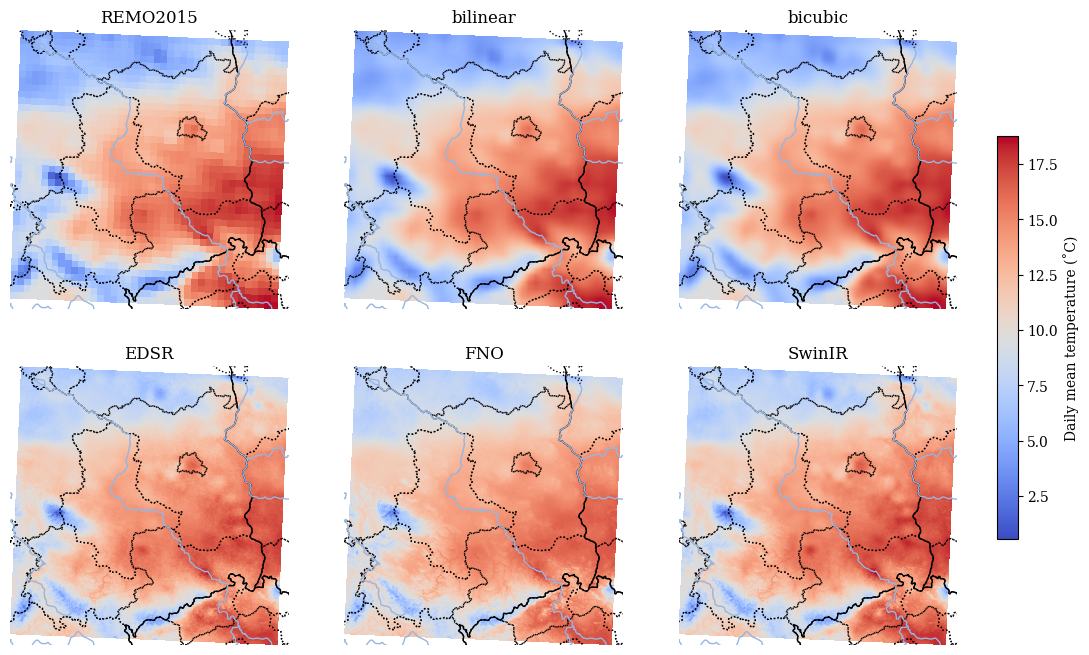

In [72]:
plot_models(
    [cordex.dev.dataset["TM"], bilinear_xr, bicubic_xr, edsr_cordex_xr, fno_cordex_xr, swin_cordex_xr],
    titles=["REMO2015", "bilinear", "bicubic", "EDSR", "FNO", "SwinIR"]
)

### Evaluation

In [61]:
measurements

,zeit,TM,Laenge,Breite,Hoehe,Name,geometry,easting,northing,rekis,rlon,rlat,cordex,bicubic,bilinear,edsr,fno,swin
Stat_ID,,,,,,,,,,,,,,,,,,
CZ_H3PODE01,2003-01-01 00:00:00+00:00,-6.8,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-7.3,-1.849871,-0.568605,0.523987,0.348615,0.334984,0.471213,0.240473,0.412541
CZ_H3PODE01,2003-01-02 00:00:00+00:00,5.3,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,5.4,-1.849871,-0.568605,6.027771,5.403883,5.356041,5.647997,5.439230,5.653710
CZ_H3PODE01,2003-01-03 00:00:00+00:00,6.4,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,6.5,-1.849871,-0.568605,4.790710,4.422959,4.400250,4.586818,4.602417,4.571879
CZ_H3PODE01,2003-01-04 00:00:00+00:00,0.6,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,0.4,-1.849871,-0.568605,3.437225,2.906554,2.878432,3.093367,3.007450,3.049273
CZ_H3PODE01,2003-01-05 00:00:00+00:00,-5.0,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-4.9,-1.849871,-0.568605,0.083862,-0.111014,-0.120951,-0.063836,-0.057378,-0.084878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PL_5101,2012-12-27 00:00:00+00:00,4.5,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,2.9,-1.681445,0.180302,-1.923218,-1.240854,-1.139339,-1.595181,-1.076237,-1.412355
PL_5101,2012-12-28 00:00:00+00:00,-0.8,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,-2.9,-1.681445,0.180302,-3.308990,-2.615664,-2.528644,-3.219910,-2.470877,-2.949405
PL_5101,2012-12-29 00:00:00+00:00,1.6,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,1.9,-1.681445,0.180302,-2.479401,-1.986635,-1.953296,-1.964796,-1.458972,-1.818408


In [62]:
#measurements.to_csv("measurements.csv")
#measurements = pd.read_csv("measurements.csv")

In [63]:
measurements = measurements.reset_index()
measurements["zeit"] = pd.to_datetime(measurements["zeit"].values).tz_localize(None)
measurements = (
    measurements.rename(columns={"zeit": "time"})
    .set_index(["Stat_ID", "time"])
)

In [64]:
measurements_xr = measurements.to_xarray()
tvars = ["TM", "rekis", "cordex", "bicubic", "bilinear", "fno", "edsr", "swin"]
for pred in tvars:
    measurements_xr[pred].attrs["standard_name"] = "air_temperature"
    measurements_xr[pred].attrs["cell_methods"] = "time: mean"
    measurements_xr[pred].attrs["units"] = "degC"

measurements_xr

<xarray.Dataset> Size: 159MB
Dimensions:   (Stat_ID: 403, time: 3653)
Coordinates:
  * Stat_ID   (Stat_ID) object 3kB 'CZ_H3PODE01' 'CZ_L2HERM01' ... 'PL_5101'
  * time      (time) datetime64[ns] 29kB 2003-01-01 2003-01-02 ... 2012-12-31
Data variables: (12/17)
    TM        (Stat_ID, time) float64 12MB -6.8 5.3 6.4 0.6 ... -0.8 1.6 1.4 3.1
    Laenge    (Stat_ID, time) float64 12MB 15.11 15.11 15.11 ... 15.33 15.33
    Breite    (Stat_ID, time) float64 12MB 50.15 50.15 50.15 ... 50.9 50.9 50.9
    Hoehe     (Stat_ID, time) float64 12MB 196.0 196.0 196.0 ... 754.0 754.0
    Name      (Stat_ID, time) object 12MB 'Podìbrady' ... 'ŚWIERADÓW-ZDRÓJ'
    geometry  (Stat_ID, time) object 12MB POINT (4722587.777732876 5561210.64...
    ...        ...
    cordex    (Stat_ID, time) float32 6MB 0.524 6.028 4.791 ... 0.9814 0.3423
    bicubic   (Stat_ID, time) float32 6MB 0.3486 5.404 4.423 ... 0.9696 0.963
    bilinear  (Stat_ID, time) float32 6MB 0.335 5.356 4.4 ... 0.9663 1.029
    edsr      (Stat_ID, time) float32 6MB 0.4712 5.648 4.587 ... 1.27 0.8661
    fno       (Stat_ID, time) float32 6MB 0.2405 5.439 4.602 ... 1.43 1.204
    swin      (Stat_ID, time) float32 6MB 0.4125 5.654 4.572 ... 1.519 0.9696

In [65]:
models = tvars.copy()
models.remove("TM")

#### Daily mean temperature (year, month, DJF, JJA)

In [66]:
def calc_daily_mean_tm(x: xr.Dataset, pred: str = "rekis", group: str = "year", ref: str = "TM") -> float:
    if group == "year":
        y = xclim.indices.tg_mean(x[ref], freq="YS")
        y_hat = xclim.indices.tg_mean(x[pred], freq="YS")
    elif group == "month":
        y = xclim.indices.tg_mean(x[ref], freq="MS")
        y_hat = xclim.indices.tg_mean(x[pred], freq="MS")
    else:
        y = xclim.indices.tg_mean(x[ref], freq="QS-DEC")
        y_hat = xclim.indices.tg_mean(x[pred], freq="QS-DEC")
        
        offset = None if group == "djf" else 2
        y = y.isel(time=slice(offset, None, 4))
        y_hat = y_hat.isel(time=slice(offset, None, 4))

    return np.sqrt(((y - y_hat) ** 2).mean().values)

In [67]:
print(f"yearly agg:")
for pred in models:
    print(f"{pred}: {calc_daily_mean_tm(measurements_xr, pred, "year"):.3f}")

yearly agg:
rekis: 0.295
cordex: 0.877
bicubic: 0.866
bilinear: 0.883
fno: 0.767
edsr: 0.772
swin: 0.763


In [69]:
print(f"monthly agg:")
for pred in models:
    print(f"{pred}: {calc_daily_mean_tm(measurements_xr, pred, "month"):.3f}")

monthly agg:
rekis: 0.349
cordex: 1.660
bicubic: 1.646
bilinear: 1.654
fno: 1.598
edsr: 1.602
swin: 1.598


In [70]:
# xclim.indices.tg_mean agg also includes trailing months like first january and february
print(f"djf agg:")
for pred in models:
    print(f"{pred}: {calc_daily_mean_tm(measurements_xr, pred, "djf"):.3f}")

djf agg:
rekis: 0.258
cordex: 1.752
bicubic: 1.746
bilinear: 1.751
fno: 1.694
edsr: 1.704
swin: 1.691


In [71]:
print(f"jja agg:")
for pred in models:
    print(f"{pred}: {calc_daily_mean_tm(measurements_xr, pred, "jja"):.3f}")

jja agg:
rekis: 0.381
cordex: 1.406
bicubic: 1.393
bilinear: 1.405
fno: 1.333
edsr: 1.336
swin: 1.335


#### Degree days (growing, cooling, heating)

In [133]:
# thresh values from: 
# https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2019JD032344
def calc_degree_days(ds: xr.Dataset, metric: str = "growing", pred: str="rekis", tas: str="TM", freq: str="YS") -> float:
    if metric == "growing":
        y = xclim.indicators.atmos.growing_degree_days(tas=tas, thresh="5 degC", freq=freq, ds=ds)
        y_hat = xclim.indicators.atmos.growing_degree_days(tas=pred, thresh="5 degC", freq=freq, ds=ds)
    elif metric == "cooling":
        y = xclim.indicators.atmos.cooling_degree_days(tas=tas, thresh="22 degC", freq=freq, ds=ds)
        y_hat = xclim.indicators.atmos.cooling_degree_days(tas=pred, thresh="22 degC", freq=freq, ds=ds)
    elif metric == "heating":
        y = xclim.indicators.atmos.heating_degree_days(tas=tas, thresh="15.5 degC", freq=freq, ds=ds)
        y_hat = xclim.indicators.atmos.heating_degree_days(tas=pred, thresh="15.5 degC", freq=freq, ds=ds)
    elif metric == "freezing":
        y = xclim.indicators.atmos.freezing_degree_days(tas=tas, thresh="0 degC", freq=freq, ds=ds)
        y_hat = xclim.indicators.atmos.freezing_degree_days(tas=pred, thresh="0 degC", freq=freq, ds=ds) 

    return np.sqrt(((y - y_hat) ** 2).mean().values)

In [74]:
print(f"growing degree days:")
for pred in models:
    print(f"{pred}: {calc_degree_days(measurements_xr, metric="growing", pred=pred):.3f}")

growing degree days:
rekis: 80.768
cordex: 258.575
bicubic: 253.687
bilinear: 256.765
fno: 240.653
edsr: 240.560
swin: 240.385


#### Cooling degree days

In [75]:
print(f"cooling degree days:")
for pred in models:
    print(f"{pred}: {calc_degree_days(measurements_xr, metric="cooling", pred=pred):.3f}")

cooling degree days:
rekis: 7.648
cordex: 31.302
bicubic: 30.344
bilinear: 30.234
fno: 30.701
edsr: 30.902
swin: 31.017


#### Heating degree days

In [76]:
print(f"heating degree days:")
for pred in models:
    print(f"{pred}: {calc_degree_days(measurements_xr, metric="heating", pred=pred):.3f}")

heating degree days:
rekis: 78.053
cordex: 260.999
bicubic: 260.301
bilinear: 265.376
fno: 226.889
edsr: 228.980
swin: 225.232


#### Freezing degree days

In [134]:
print(f"freezing degree days:")
for pred in models:
    print(f"{pred}: {calc_degree_days(measurements_xr, metric="freezing", pred=pred):.3f}")

freezing degree days:
rekis: 17.348
cordex: 106.999
bicubic: 106.235
bilinear: 106.689
fno: 101.671
edsr: 102.459
swin: 101.394


#### Graph yearly mean temperature

In [78]:
def calc_daily_mean_tm(x: xr.Dataset, pred: str = "swin", baseline: str = "cordex", ref: str = "TM") -> float:
    y = xclim.indices.tg_mean(x[ref], freq="YS")
    y_hat_cordex = xclim.indices.tg_mean(x[baseline], freq="YS")
    y_hat_model = xclim.indices.tg_mean(x[pred], freq="YS")

    cordex_err = np.sqrt(((y - y_hat_cordex) ** 2).mean(dim="Stat_ID"))
    model_err = np.sqrt(((y - y_hat_model) ** 2).mean(dim="Stat_ID"))

    import pandas as pd
    df = pd.DataFrame({
        "Year": cordex_err.time.values,
        "REMO2015": cordex_err.values,
        "SwinIR": model_err.values
    })
    df = df.melt(id_vars="Year", var_name="Model", value_name="RMSE")

    sns.set_style("darkgrid")

    plt.figure(figsize=(10, 3.5))
    sns.lineplot(data=df, x="Year", y="RMSE", hue="Model", linewidth=2.5, palette=["#1f77b4", "#2ca02c"])
    
    #plt.title("Annual Temperature RMSE", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("RMSE (°C)", fontsize=12)
    plt.legend(title="", fontsize=12)
    plt.tick_params(axis='both', labelsize=12)
    
    plt.tight_layout()
    #plt.savefig("annual_rmse.pdf", dpi=300, bbox_inches="tight")
    
    plt.show()
    
    return model_err.mean().item()

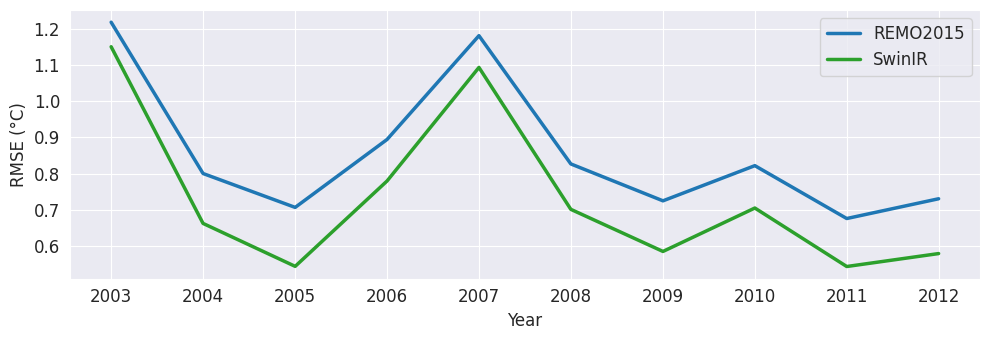

0.7339885996863109


In [79]:
print(calc_daily_mean_tm(measurements_xr))

In [80]:
def calc_daily_mean_tm_station(x: xr.Dataset, pred: str = "swin", baseline: str = "cordex", ref: str = "TM", station: str = "PL_5101") -> float:
    y = xclim.indices.tg_mean(x[ref], freq="YS").sel(Stat_ID = station)
    y_hat_cordex = xclim.indices.tg_mean(x[baseline], freq="YS").sel(Stat_ID = station)
    y_hat_model = xclim.indices.tg_mean(x[pred], freq="YS").sel(Stat_ID = station)

    fig, ax = plt.subplots(figsize=(7, 4))
    
    y.plot(ax=ax, label=f"{station} station", color="green", linewidth=2, linestyle="--")
    y_hat_cordex.plot(ax=ax, label="REMO2015", color="blue", linewidth=2, linestyle="--")
    y_hat_model.plot(ax=ax, label="SwinIR", color="orange", linewidth=2)
    
    # Titles and labels
    ax.set_title("Annual Mean Temperature")
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Temperature (°C)", fontsize=12)
    
    # Grid & ticks
    ax.grid(True, which="major", linestyle=":", linewidth=0.7, alpha=0.7)
    ax.tick_params(axis="both", labelsize=10)
    
    ax.legend()
    
    plt.tight_layout()
    plt.show()

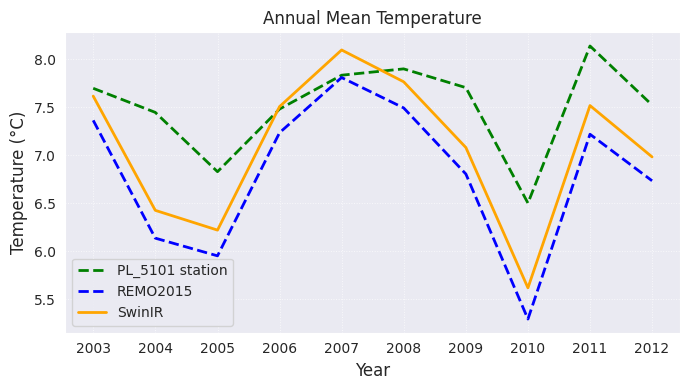

In [81]:
calc_daily_mean_tm_station(measurements_xr)

#### Temperature distribution

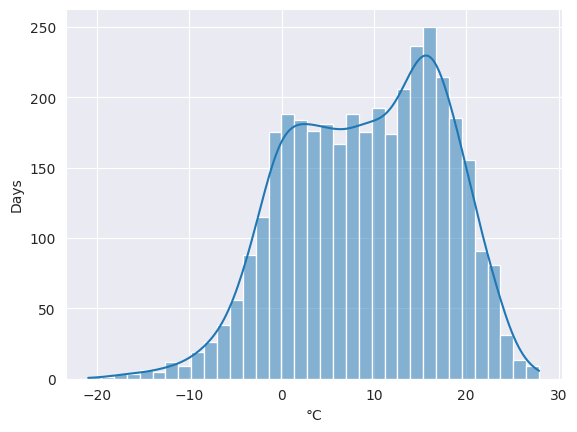

In [136]:
tm = measurements_xr["cordex"].mean(dim="Stat_ID").values
sns.histplot(tm, bins=35, kde=True)
#counts, bins = np.histogram(tm, bins=35)

plt.xlabel("°C")
plt.ylabel("Days")
plt.show()

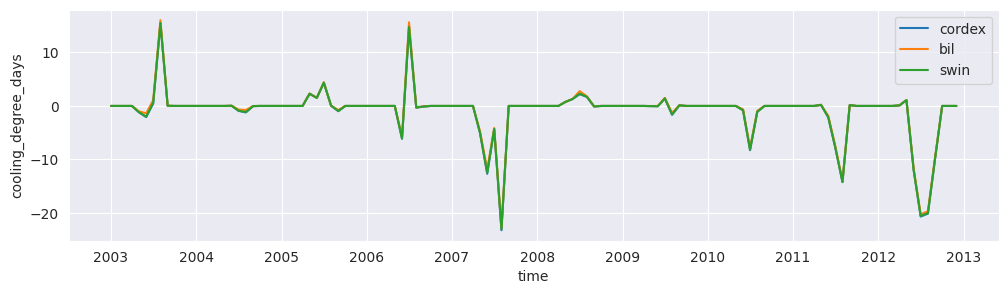

In [132]:
y = xclim.indicators.atmos.cooling_degree_days(tas="TM", thresh="22 degC", freq="MS", ds=measurements_xr)
y_hat = xclim.indicators.atmos.cooling_degree_days(tas="cordex", thresh="22 degC", freq="MS", ds=measurements_xr)
y_bil = xclim.indicators.atmos.cooling_degree_days(tas="bilinear", thresh="22 degC", freq="MS", ds=measurements_xr)
y_swin = xclim.indicators.atmos.cooling_degree_days(tas="swin", thresh="22 degC", freq="MS", ds=measurements_xr)

fig, ax = plt.subplots(figsize=(12, 3))

# y.mean(dim="Stat_ID").plot(ax=ax, label="TM")
(y - y_hat).mean(dim="Stat_ID").plot(ax=ax, label="cordex")
(y - y_bil).mean(dim="Stat_ID").plot(ax=ax, label="bil")
(y - y_swin).mean(dim="Stat_ID").plot(ax=ax, label="swin")

ax.legend()
plt.show()